In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.MNIST(
    root="dataset",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10).scatter_(0, torch.tensor(y), 1))
)

test_data = datasets.MNIST(
    root="dataset",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, pin_memory=True, pin_memory_device='cuda')
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=True, pin_memory_device='cuda')

In [4]:
device = 'cuda'

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits


In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader , model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred: torch.Tensor = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")




In [6]:
model = NeuralNetwork().to(device)


In [7]:
epochs = 50
lr = 0.005

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302128  [   64/60000]
loss: 2.302786  [ 6464/60000]
loss: 2.302218  [12864/60000]
loss: 2.301742  [19264/60000]
loss: 2.302118  [25664/60000]
loss: 2.301205  [32064/60000]
loss: 2.301224  [38464/60000]
loss: 2.301234  [44864/60000]
loss: 2.301561  [51264/60000]
loss: 2.301000  [57664/60000]
Test Error: 
 Accuracy: 23.7%, Avg loss: 2.300572 

Epoch 2
-------------------------------
loss: 2.300824  [   64/60000]
loss: 2.300364  [ 6464/60000]
loss: 2.299436  [12864/60000]
loss: 2.299784  [19264/60000]
loss: 2.300113  [25664/60000]
loss: 2.299090  [32064/60000]
loss: 2.299312  [38464/60000]
loss: 2.298871  [44864/60000]
loss: 2.298990  [51264/60000]
loss: 2.297632  [57664/60000]
Test Error: 
 Accuracy: 42.3%, Avg loss: 2.298192 

Epoch 3
-------------------------------
loss: 2.299103  [   64/60000]
loss: 2.298194  [ 6464/60000]
loss: 2.297783  [12864/60000]
loss: 2.297693  [19264/60000]
loss: 2.296678  [25664/60000]
loss: 2.296658  [32064/600

/tmp/ipykernel_53279/2231731645.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cuimg = torch.tensor(img).to(device)


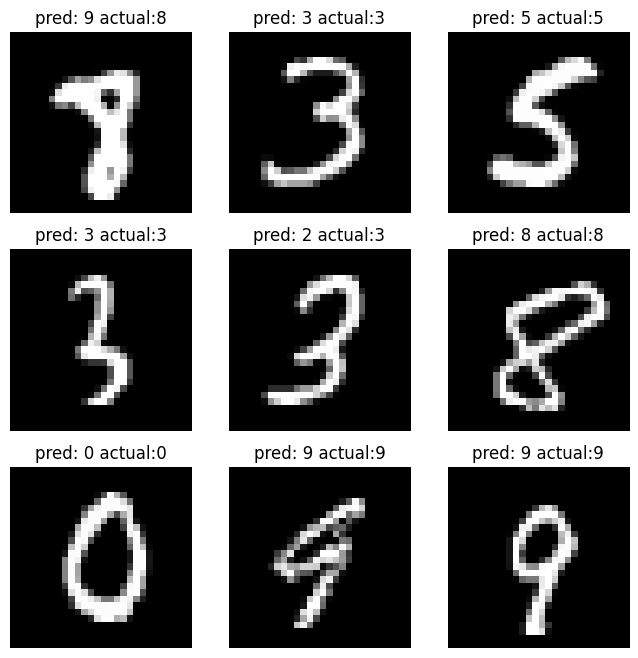

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    cuimg = torch.tensor(img).to(device)
    pred = model(cuimg)
    pred_label = pred.argmax(1).item()
    figure.add_subplot(rows, cols, i)
    plt.title(f"pred: {pred_label} actual:{label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
torch.save(model.state_dict())